## Занятие 8. Поиск ключевых точек и сопоставление изображений
#### Часть 3. Сопоставление с помощью нейросетей
**Алгоритм**:

0. Найти ключевые точки (КТ) на R
1. Найти ключевые КТ на Q
2. Сопоставить КТ Q и R друг-другу
3. На основе сопоставления точек найти гомографию из Q в R

Полная аналогия с пайплайном на классическом CV, но вместо классических CV-алгоритмов - нейросети. 
1. Детектор ключевых точек: SIFT -> SuperPoint
2. Матч ключевых точек: KNN -> SuperGlue

## Для работы ноутбука - должен быть склонен SuperGlue

In [139]:
!git clone https://github.com/magicleap/SuperGluePretrainedNetwork/

Cloning into 'SuperGluePretrainedNetwork'...
Updating files: 100% (89/89), done.


### 3.1 SuperPoint
[SuperPoint: Self-Supervised Interest Point Detection and Description](https://openaccess.thecvf.com/content_cvpr_2018_workshops/papers/w9/DeTone_SuperPoint_Self-Supervised_Interest_CVPR_2018_paper.pdf)


In [144]:
import sys
import torch
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

BASE_PATH = Path().absolute()
assert BASE_PATH.name == 'c08'

In [181]:
plt.rcParams['figure.figsize'] = [15, 8]

In [145]:
gpu = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu:0')
gpu = torch.device('cpu:0')

In [147]:
sys.path.insert(0, str((BASE_PATH / "SuperGluePretrainedNetwork").absolute()))

In [148]:
import matplotlib

_backend = matplotlib.get_backend()

from models.superpoint import SuperPoint
from models.utils import read_image

matplotlib.use(_backend)
%matplotlib inline


In [149]:
spoint = SuperPoint({'keypoint_threshold': 0.05}).to(gpu)

Loaded SuperPoint model


In [150]:
img1, img1_t, _ = read_image(
    BASE_PATH/ 'hpatches_tiny'/'v_bird'/'1.ppm',
    device=gpu,
    resize=(640, 480), 
    rotation=0, 
    resize_float=True
)

img2, img2_t, _ = read_image(
    BASE_PATH/ 'hpatches_tiny'/'v_bird'/'2.ppm',
    device=gpu,
    resize=(640, 480), 
    rotation=0, 
    resize_float=True
)

In [151]:
print(f"N parameters: {sum([p.numel() for p in spoint.parameters()])}")
spoint

N parameters: 1300865


SuperPoint(
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPb): Conv2d(256, 65, kernel_size=(1, 1), stride=(1, 1))
  (convDa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convDb): Conv2d(25

In [158]:
with torch.no_grad():
    kpt1 = spoint({'image': img1_t})

kpt1.keys()

dict_keys(['keypoints', 'scores', 'descriptors'])

In [159]:
kpt1['keypoints'][0].shape, kpt1['scores'][0].shape, kpt1['descriptors'][0].shape

(torch.Size([894, 2]), torch.Size([894]), torch.Size([256, 894]))

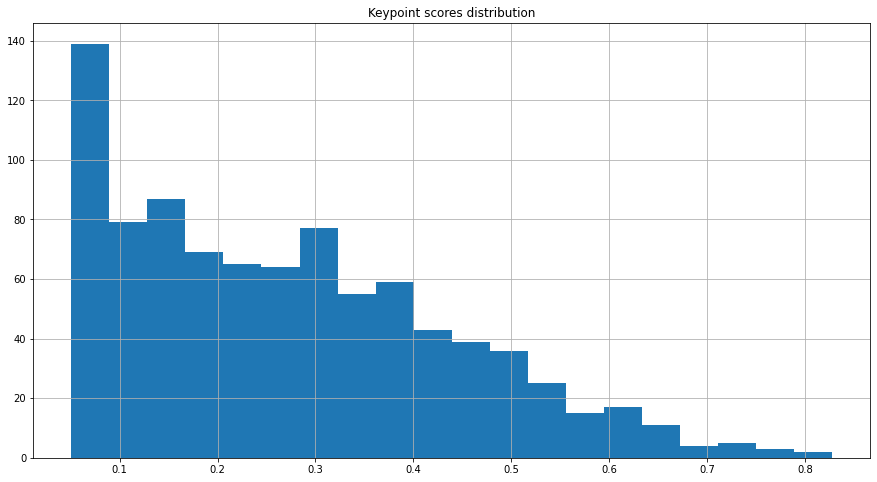

In [182]:
plt.hist(kpt1['scores'][0].numpy().flatten(), bins=20)
plt.title("Keypoint scores distribution")
plt.grid()

In [183]:
kps_conf = kpt1['keypoints'][0][kpt1['scores'][0] > 0.5]

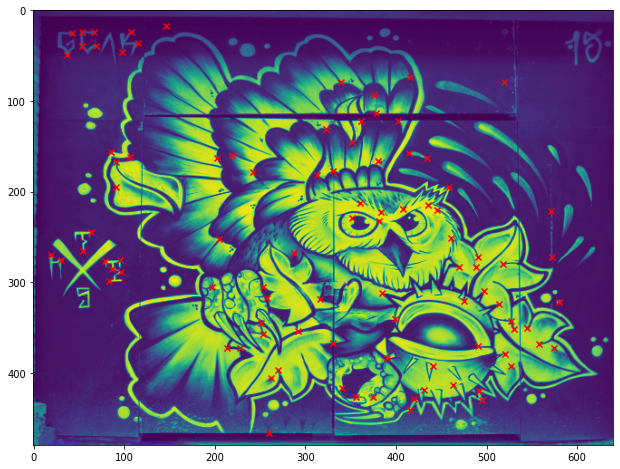

In [184]:
plt.imshow(img1_t[0, 0])

# put a blue dot at (10, 20)
plt.scatter(kps_conf[:, 0], kps_conf[:, 1], c='r', marker='x')


Особенности сети
#### Итеративный NMS

In [185]:
def simple_nms(scores, nms_radius: int, iters=2):
    """ Fast Non-maximum suppression to remove nearby points """
    assert(nms_radius >= 0)

    def max_pool(x):
        return torch.nn.functional.max_pool2d(
            x, kernel_size=nms_radius*2+1, stride=1, padding=nms_radius)

    zeros = torch.zeros_like(scores)
    max_mask = scores == max_pool(scores)
    for _ in range(iters):
        supp_mask = max_pool(max_mask.float()) > 0
        supp_scores = torch.where(supp_mask, zeros, scores)
        new_max_mask = supp_scores == max_pool(supp_scores)
        max_mask = max_mask | (new_max_mask & (~supp_mask))
    return torch.where(max_mask, scores, zeros)

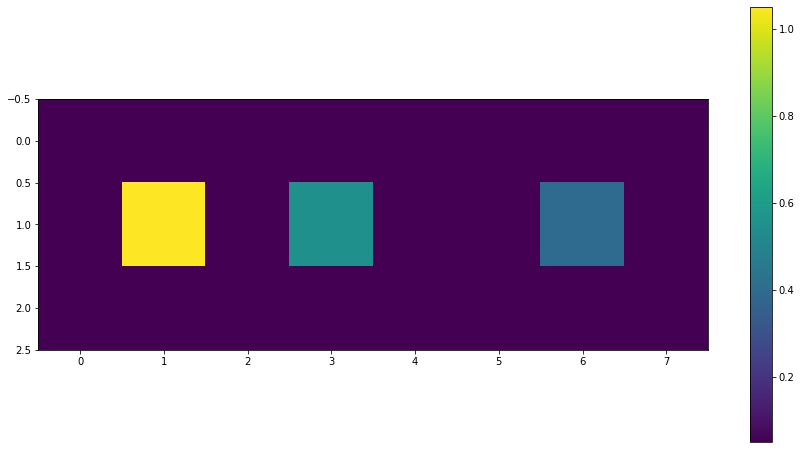

In [186]:
t = torch.tensor([
    [0, 0., 0, 0.0, 0, 0, 0.0, 0],
    [0, 1., 0, 0.5, 0, 0, 0.35, 0],
    [0, 0., 0, 0.0, 0, 0, 0.0, 0]
])[None, None] + 0.05

plt.imshow(t[0,0].numpy())
plt.colorbar()

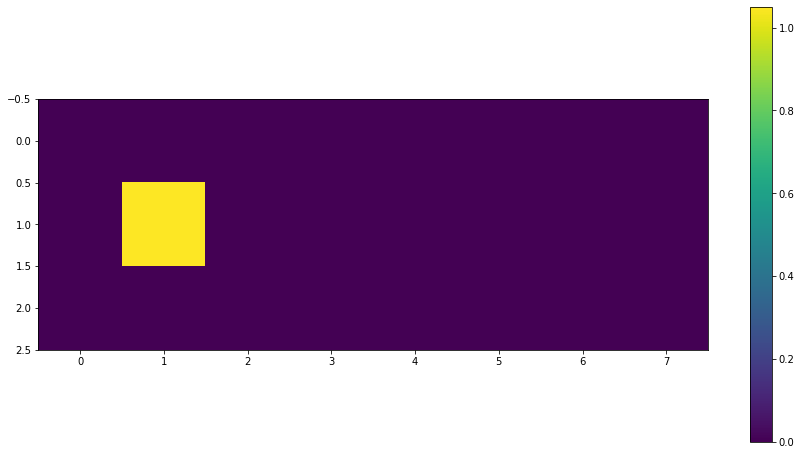

In [195]:
plt.imshow(simple_nms(t, 3, iters=0)[0,0].numpy())
plt.colorbar()

#### PixelShuffle

In [196]:
ps = torch.nn.PixelShuffle(upscale_factor=2)

In [283]:
_c, _h, _w = 4*1, 2, 3
t = torch.arange(_h*_w).view(1, 1, _h, _w) * 10 + (torch.arange(_c)).view(1, _c, 1, 1)
t

tensor([[[[ 0, 10, 20],
          [30, 40, 50]],

         [[ 1, 11, 21],
          [31, 41, 51]],

         [[ 2, 12, 22],
          [32, 42, 52]],

         [[ 3, 13, 23],
          [33, 43, 53]]]])

In [284]:
t[0, 0]

tensor([[ 0, 10, 20],
        [30, 40, 50]])

In [285]:
ps(t)

tensor([[[[ 0,  1, 10, 11, 20, 21],
          [ 2,  3, 12, 13, 22, 23],
          [30, 31, 40, 41, 50, 51],
          [32, 33, 42, 43, 52, 53]]]])

In [256]:
ps(t).shape

torch.Size([1, 1, 4, 6])

In [278]:
from einops import rearrange

ps_t = rearrange(t, "b (c c1 c2) h w -> b c (h c1) (w c2)", c1=2, c2=2)
torch.allclose(ps_t, ps(t))


True

### Grid Sample

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:4079: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


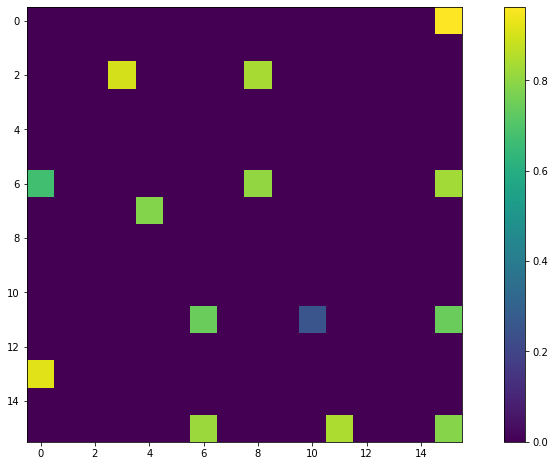

In [286]:
scores = simple_nms(
    torch.nn.functional.upsample_bilinear(torch.rand(1, 1, 8, 8), scale_factor=2),
    3
)
plt.imshow(scores[0, 0])
plt.colorbar()

torch.Size([4])
torch.Size([6, 4, 4])


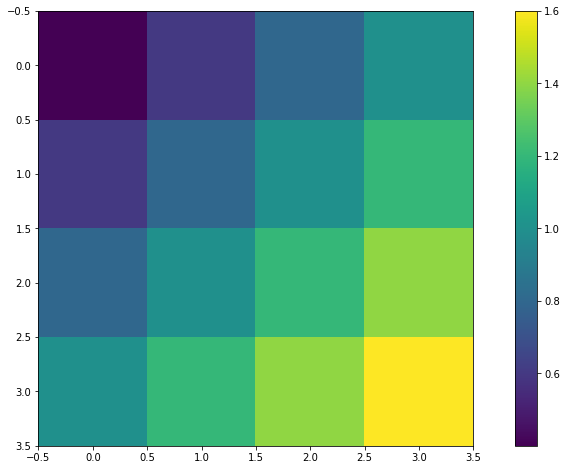

In [316]:
_d = torch.linspace(0.2, 0.8, 4)
print(_d.shape)
descriptors_2d = torch.zeros(6, 4, 4) + _d.view(1, -1, 1) + _d.view(1, 1, -1)
#(_d[None, :, None] + _d[None, None, :]) * torch.ones(6)[:, None, None]
plt.imshow(descriptors_2d[4])
plt.colorbar()
print(descriptors_2d.shape)

In [323]:
keypoints = torch.nonzero(scores[0, 0] > 0.1)
keypoints

tensor([[ 0, 15],
        [ 2,  3],
        [ 2,  8],
        [ 6,  0],
        [ 6,  8],
        [ 6, 15],
        [ 7,  4],
        [11,  6],
        [11, 10],
        [11, 15],
        [13,  0],
        [15,  6],
        [15, 11],
        [15, 15]])

In [326]:
scaled_keypoints = keypoints.float() 
scaled_keypoints /= (16 - 1)
scaled_keypoints = scaled_keypoints * 2 - 1

scaled_keypoints

tensor([[-1.0000,  1.0000],
        [-0.7333, -0.6000],
        [-0.7333,  0.0667],
        [-0.2000, -1.0000],
        [-0.2000,  0.0667],
        [-0.2000,  1.0000],
        [-0.0667, -0.4667],
        [ 0.4667, -0.2000],
        [ 0.4667,  0.3333],
        [ 0.4667,  1.0000],
        [ 0.7333, -1.0000],
        [ 1.0000, -0.2000],
        [ 1.0000,  0.4667],
        [ 1.0000,  1.0000]])

In [331]:
descriptors = torch.nn.functional.grid_sample(
        descriptors_2d[None], scaled_keypoints.reshape(1, 1, -1, 2), mode='bilinear'
)
descriptors.shape

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


torch.Size([1, 6, 1, 14])

In [335]:
descriptors[..., 1]

tensor([[[0.4667],
         [0.4667],
         [0.4667],
         [0.4667],
         [0.4667],
         [0.4667]]])

### 3.2 SuperGlue
[SuperGlue: Learning Feature Matching With Graph Neural Networks](https://openaccess.thecvf.com/content_CVPR_2020/papers/Sarlin_SuperGlue_Learning_Feature_Matching_With_Graph_Neural_Networks_CVPR_2020_paper.pdf)


In [336]:
from models.superglue import SuperGlue

In [337]:
sglue = SuperGlue(config={'match_threshold': 0.5}).to(gpu)
print(f"N parameters: {sum([p.numel() for p in sglue.parameters()])}")


Loaded SuperGlue model ("indoor" weights)
N parameters: 12023297


In [338]:
kpt1 = spoint({'image': img1_t})
kpt2 = spoint({'image': img2_t})


In [366]:
sg_input = dict()
for (k, v) in kpt1.items():
    sg_input[k + '0'] = torch.stack(v, axis=0).to(gpu)

for (k, v) in kpt2.items():
    sg_input[k + '1'] = torch.stack(v, axis=0).to(gpu)
    
sg_input['image0'] = img1_t
sg_input['image1'] = img2_t

In [367]:
with torch.no_grad():
    sg_output = sglue(sg_input)
sg_output.keys()

dict_keys(['matches0', 'matches1', 'matching_scores0', 'matching_scores1'])

In [368]:
sg_output['matches0'];

In [369]:
sg_output['matching_scores0']

tensor([[0.0000, 0.7184, 0.5349, 0.0000, 0.6849, 0.4735, 0.8419, 0.8851, 0.0000,
         0.9235, 0.0000, 0.0000, 0.7106, 0.3345, 0.4358, 0.5869, 0.0000, 0.5077,
         0.5915, 0.3835, 0.0000, 0.0000, 0.1754, 0.3467, 0.8825, 0.5621, 0.0000,
         0.2847, 0.0000, 0.3203, 0.0000, 0.4066, 0.8830, 0.6508, 0.3908, 0.1794,
         0.8397, 0.1194, 0.0000, 0.2768, 0.6934, 0.2819, 0.0000, 0.0000, 0.2893,
         0.0000, 0.5536, 0.0000, 0.7126, 0.0000, 0.5083, 0.2150, 0.4832, 0.2540,
         0.0000, 0.6490, 0.4994, 0.4311, 0.4177, 0.4215, 0.8725, 0.0000, 0.0000,
         0.4325, 0.0000, 0.6664, 0.1751, 0.0000, 0.7372, 0.0000, 0.4091, 0.1753,
         0.0000, 0.6369, 0.4937, 0.0000, 0.0000, 0.5519, 0.8481, 0.0000, 0.9689,
         0.0000, 0.8835, 0.4465, 0.4577, 0.4766, 0.3754, 0.9038, 0.7367, 0.2401,
         0.0000, 0.4847, 0.7314, 0.0000, 0.9321, 0.5985, 0.3320, 0.6316, 0.6976,
         0.6714, 0.0000, 0.0000, 0.6160, 0.0000, 0.4910, 0.6648, 0.3897, 0.7028,
         0.4813, 0.4990, 0.5

In [370]:
def extract_matched_keypoints(sg_in, sg_out):
    idx0 = sg_out['matches0'] > -1
    kpts0 = sg_in['keypoints0'][0][idx0[0]]
    idx1 = sg_out['matches0'][idx0]
    kpts1 = sg_in['keypoints1'][0][idx1]
    return kpts0, kpts1

kp_matched0, kp_matched1 = extract_matched_keypoints(sg_input, sg_output)
kp_matched0.shape, kp_matched1.shape

(torch.Size([355, 2]), torch.Size([355, 2]))

In [371]:
import matplotlib.cm as cm
from models.utils import make_matching_plot, make_matching_plot_fast

def show_results(sg_in, sg_out):
    img0 = sg_in['image0'].numpy().squeeze()
    img1 = sg_in['image1'].numpy().squeeze()
    
    kpts0 = sg_in['keypoints0'][0].cpu().numpy()
    kpts1 = sg_in['keypoints1'][0].cpu().numpy()
    matches = sg_out['matches0'][0].cpu().numpy()
    confidence = sg_out['matching_scores0'][0].cpu().numpy()
    valid = matches > -1
    mkpts0 = kpts0[valid]
    mkpts1 = kpts1[matches[valid]]
    color = cm.jet(confidence[valid])

    out = make_matching_plot_fast(
            img0, img1, kpts0, kpts1, mkpts0, mkpts1, color, "",
            path=None, show_keypoints=True, small_text=""
    )
    return out



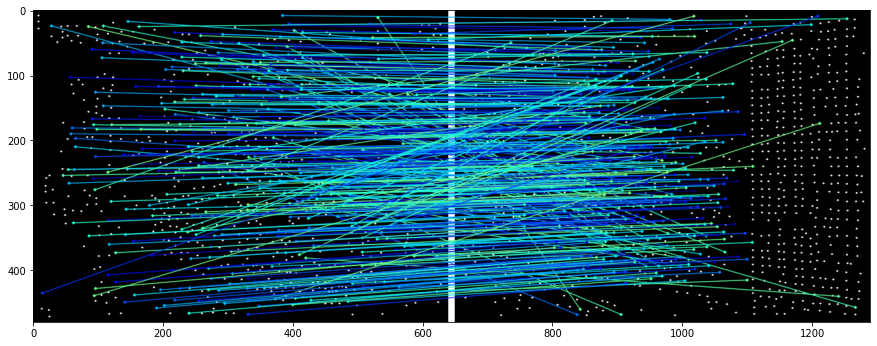

In [372]:
plt.imshow(show_results(sg_input, sg_output))

### 3.3 Sinkhorn Iterations
https://openaccess.thecvf.com/content/CVPR2022/papers/Eisenberger_A_Unified_Framework_for_Implicit_Sinkhorn_Differentiation_CVPR_2022_paper.pdf

In [345]:
from models.superglue import log_optimal_transport

In [346]:
t = (torch.randn((1, 4, 6)) - 0.5) * 5
t

tensor([[[ -0.1222,  -0.3803,   2.1121,   1.2186,  -3.6165,  -2.0468],
         [  1.4215,  -2.4007, -10.8995,  -1.0299,  -6.0454,  -8.3344],
         [ -6.9733,  -0.1336,  -2.5210,   1.3208,  -9.1130,  -5.7857],
         [ -8.4690,  -4.6055,   0.2879,  -4.3601,  -4.9125,  -5.7837]]])

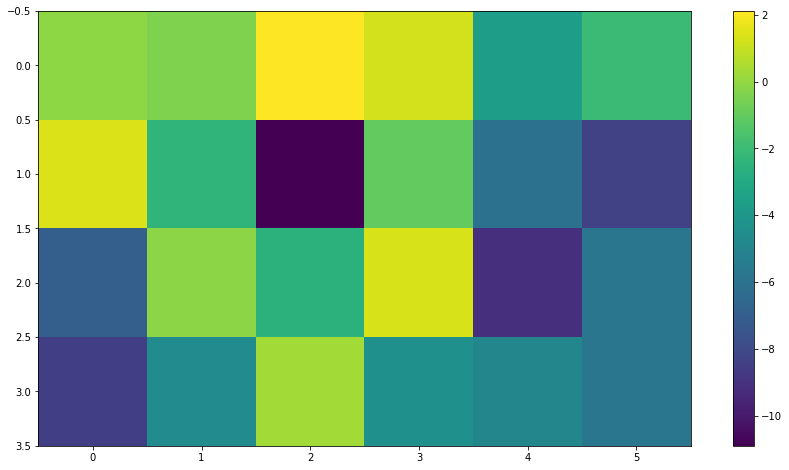

In [347]:
plt.imshow(t[0])
plt.colorbar()

In [348]:
alpha = torch.Tensor([0.0042])

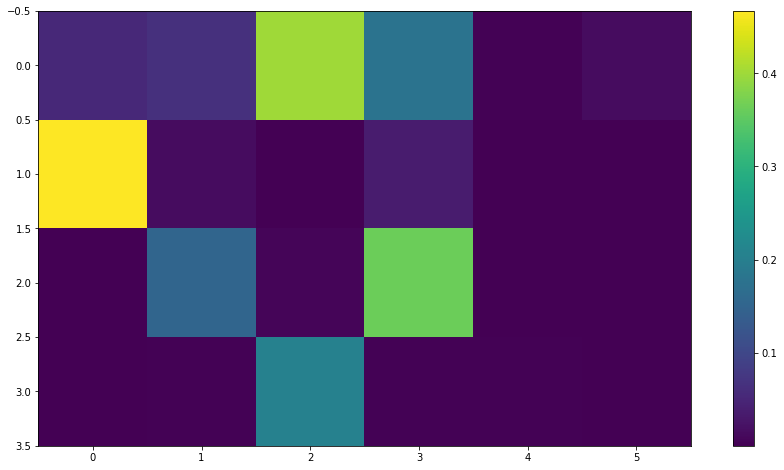

In [349]:
plt.imshow(torch.exp(log_optimal_transport(t, alpha, 2))[0, :-1, :-1])
plt.colorbar()

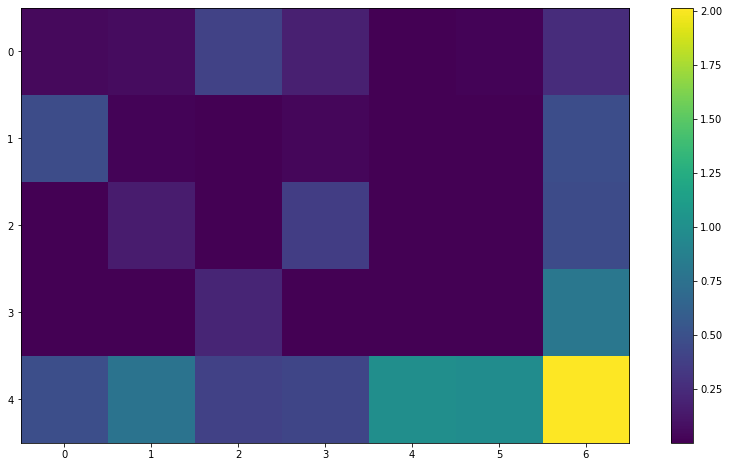

In [351]:
plt.imshow(torch.exp(log_optimal_transport(t, alpha, 2))[0])
plt.colorbar()

In [352]:
# сумма по 1 оси
# Сумма dustbin = N
torch.exp( # Матрица возводится в экспоненту!
    log_optimal_transport(t, alpha, 2)
).numpy().round(2).sum(axis=1)

array([[1.  , 0.99, 1.  , 1.  , 0.99, 1.  , 3.99]], dtype=float32)

In [353]:
# сумма по 2 оси
# Сумма dustbin = M
(torch.exp(log_optimal_transport(t, alpha, 2))).numpy().round(2).sum(axis=2)

array([[0.96     , 1.       , 0.98     , 1.       , 6.0299997]],
      dtype=float32)

In [354]:
# Сумма всей матрицы
# M + N
(torch.exp(log_optimal_transport(t, alpha, 2))).numpy().round(2).sum()

9.97

In [355]:
# Результаты при 1 итерации
torch.exp(log_optimal_transport(t, alpha, 1)).numpy().round(2)

array([[[0.04, 0.04, 0.29, 0.13, 0.  , 0.01, 0.16],
        [0.45, 0.02, 0.  , 0.04, 0.  , 0.  , 0.42],
        [0.  , 0.14, 0.01, 0.36, 0.  , 0.  , 0.41],
        [0.  , 0.  , 0.28, 0.  , 0.  , 0.  , 0.99],
        [0.52, 0.79, 0.43, 0.47, 0.99, 0.99, 2.01]]], dtype=float32)

In [356]:
# Результаты при 3 итерациях (разница большая с iters=1)
torch.exp(log_optimal_transport(t, alpha, 3)).numpy().round(2)

array([[[0.05, 0.07, 0.41, 0.18, 0.  , 0.02, 0.26],
        [0.47, 0.02, 0.  , 0.04, 0.  , 0.  , 0.48],
        [0.  , 0.16, 0.01, 0.36, 0.  , 0.  , 0.47],
        [0.  , 0.  , 0.2 , 0.  , 0.  , 0.  , 0.79],
        [0.48, 0.76, 0.38, 0.42, 0.99, 0.98, 2.  ]]], dtype=float32)

In [357]:
# Результаты при 10 итерациях (разница не оч большая с iters=3)
torch.exp(log_optimal_transport(t, alpha, 10)).numpy().round(2)

array([[[0.05, 0.07, 0.41, 0.18, 0.  , 0.02, 0.26],
        [0.47, 0.02, 0.  , 0.04, 0.  , 0.  , 0.48],
        [0.  , 0.16, 0.01, 0.36, 0.  , 0.  , 0.47],
        [0.  , 0.  , 0.2 , 0.  , 0.  , 0.  , 0.79],
        [0.48, 0.76, 0.38, 0.41, 0.99, 0.98, 2.  ]]], dtype=float32)

### Задача-3. Используя cv2.findHomography и нейросети, напишите пайплайн нейронного матчинга

In [360]:
import cv2
SGLUE = sglue
SPOINT = spoint

In [375]:
def neural_matching_pipeline(img_Q_tensor, img_R_tensor):
    """
    Находит отображение Query в Reference, применяет его к изображению
    """
    return cv2.warpPerspective(img_Q_tensor.numpy()[0, 0], P, dsize=(img_R_tensor.shape[-1], img_R_tensor.shape[-2]))


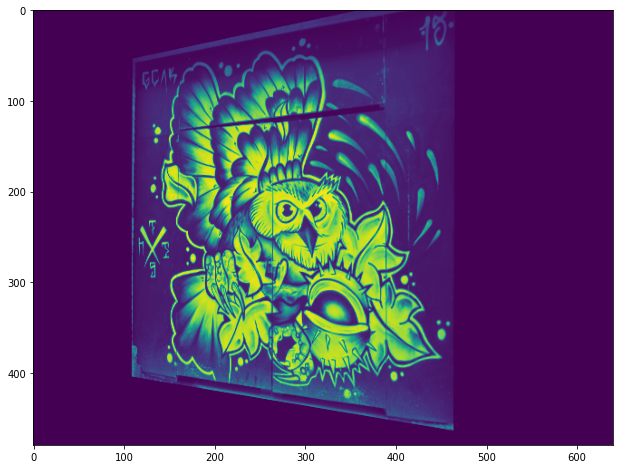

In [376]:
plt.imshow(neural_matching_pipeline(img1_t, img2_t))

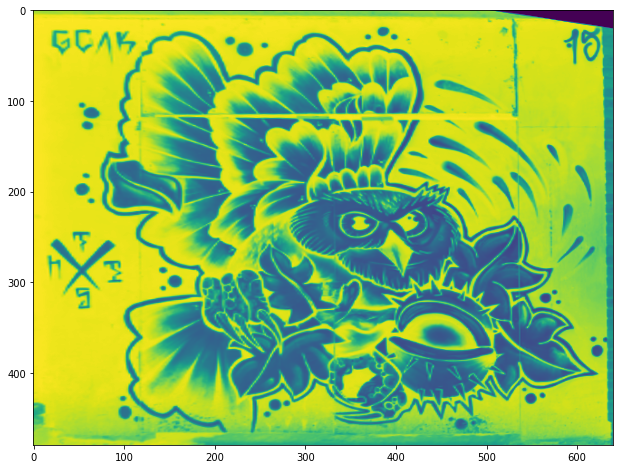

In [378]:
plt.imshow(neural_matching_pipeline(1 - img2_t, img1_t))

### Сравнение результатов разных методов

[Image Matching Across Wide Baselines: From Paper to Practice](https://arxiv.org/pdf/2003.01587.pdf)